# HW2 Python Solutions

## Problem 6?: Coherent States of the Quantum Harmonic Oscillator (QHO)

- We want to study coherent states of the quantum harmonic oscillator (QHO) and assume the system has the initial wavefunction psi(x, 0) = phi_0(x - x_0), where x_0 is a constant representing the displacement of the Gaussian ground-state waveform from the origin.

- We need to:

  - **(a)** Plot the wavefunction by choosing x_0 = sqrt(hbar * m * omega).  
  - **(b)** Calculate the overlap integrals (c_n = <n|psi(0)>) necessary to express the initial wavefunction in terms of energy eigenstates. We will do this for the first 10 energy levels. Compare the results to:

    c_0 = (alpha^n / sqrt(n!)) * exp(-alpha^2 / 2)

    where alpha = x_0 * sqrt(m * omega / (2 * hbar)). Check whether the first 10 terms are enough to properly represent the wavefunction and explain.

  - **(c)** Calculate the expectation value of energy.
  
  - **(d)** Construct the time-dependent wavefunction, animate thefunctiontion, and describe its time evolution.
  
  - **(e)** Writefunctiontions to generalize the solution: As x_0 = 4 * sqrt(hbar * m * omega) given hint we may need to use more than 10 terms.


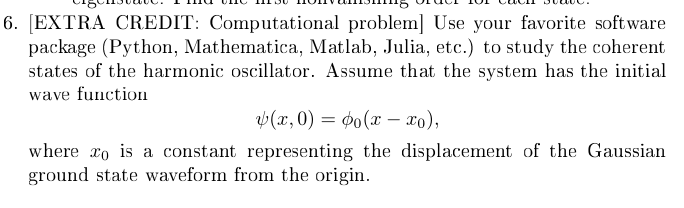

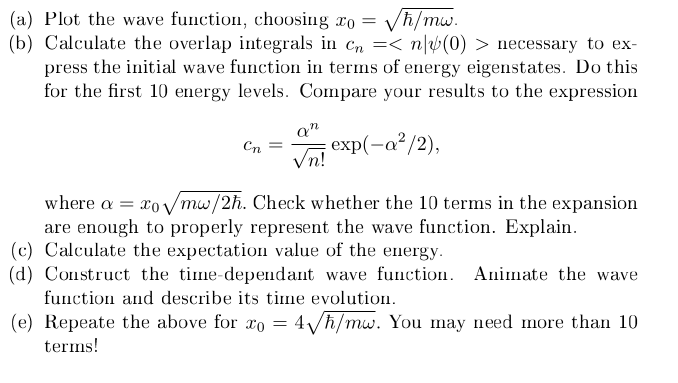

In [3]:
from IPython.display import Image
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.special import hermite, factorial, eval_hermite
import os
import glob
import shutil
import matplotlib.style as style
style.use('dark_background')
plt.rcParams['text.usetex'] = False
#test

#display screenshots
for i in range(1, 3):
    display(Image(filename=f'p_statement/p6_{i}.png'))

In [4]:
def initial_wavefunction(x, x_0, m, omega, hbar):
    '''
    calculate the initial wavefunction psi(x, 0) for a coherent state.
    args:
        x (array): position values
        x_0 (float): displacement of the gaussian ground-state from the origin
        m (float): mass of the particle
        omega (float): angular frequency
        hbar (float): reduced planck constant
    returns:
        psi (array): computed wavefunction values
    '''
    alpha = np.sqrt(m * omega / hbar)
    norm = alpha / np.pi**0.25
    return norm * np.exp(-0.5 * alpha**2 * (x - x_0)**2)


def plot_wavefunction(x, wavefunction, x_0, m, omega, hbar, save_as_png=False, file_name=None):
    '''
    plot the wavefunction as a function of x.
    args:
        x (array): x values for plotting
        wavefunction (array): computed coherent state wavefunction
        x_0 (float): displacement used in the coherent state
        m (float): mass of the particle
        omega (float): angular frequency
        hbar (float): reduced planck constant
        save_as_png (bool): if true, saves the plot as a png file
        file_name (str): file name for saving the png
    returns:
        none
    '''
    #compute the ground state wavefunction (unshifted)
    psi_ground = initial_wavefunction(x, 0, m, omega, hbar)
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, wavefunction, label=f'coherent state: x0 = {x_0}', color='b')
    plt.plot(x, psi_ground, 'r--', label='ground state gaussian')
    plt.xlabel('x')
    plt.ylabel('psi(x, 0)')
    plt.title('initial wavefunction of the coherent state')
    plt.legend()
    plt.grid(True)
    
    if save_as_png and file_name:
        plt.savefig(file_name, format='png')
        print(f'plot saved as {file_name}')
    else:
        plt.show()




def overlap_integrals(n_max, x, x_0, m, omega, hbar):
    '''
    compute the overlap integrals c_n = integral[ psi_n(x)*psi_coherent(x,0) dx ]
    for n = 0 to n_max - 1.
    args:
        n_max (int): number of energy levels to compute
        x (array): position values for integration
        x_0 (float): displacement used for the coherent state
        m, omega, hbar: parameters of the harmonic oscillator
    returns:
        array of coefficients c_n
    '''
    psi_coherent = initial_wavefunction(x, x_0, m, omega, hbar)
    c_n = []
    for n in range(n_max):
        psi_n_vals = psi_n(n, x, m, omega, hbar)
        # compute the integral using the trapezoidal rule
        cn = np.trapezoid(psi_n_vals * psi_coherent, x)
        c_n.append(cn)
    return np.array(c_n)

def analytic_coefficients(n_max, x_0, m, omega, hbar):
    '''
    compute the analytic expansion coefficients for a coherent state.
    the analytic expression is:
      c_n = exp(-alpha^2/2) * (alpha^n / sqrt(n!))
    where alpha = x_0 * sqrt(m * omega/(2 * hbar))
    args:
        n_max (int): number of coefficients to compute (for n=0 to n_max-1)
        x_0 (float): displacement of the coherent state
        m, omega, hbar: oscillator parameters
    returns:
        array of analytic coefficients c_n
    '''
    alpha = x_0 * np.sqrt(m * omega/(2 * hbar))
    c_n = []
    for n in range(n_max):
        cn = np.exp(-0.5 * alpha**2) * (alpha**n/np.sqrt(factorial(n)))
        c_n.append(cn)
    return np.array(c_n)

#function to compute expectation value of energy
def expectation_value_energy(c_n, omega, hbar):
    #energy eigenvalues for first n energy levels
    E_n = [(n + 0.5) * hbar * omega for n in range(len(c_n))]

    #expectation energy
    expectation_energy = sum(np.abs(c_n[n])**2 * E_n[n] for n in range(len(c_n)))
    
    return expectation_energy

#function to construct time-dependent wavefunction
def time_dependent_wavefunction(x, t, c_n, omega, hbar):
    """
    make time-dependent wavefunction psi(x, t).
    args:
        x (array): position values
        t (float): time value
        c_n (array): expansion coefficients
        omega (float): angular frequency
        hbar (float): reduced Planck constant
    returns:
        psi_t (array): time-dependent wavefunction
    """
    psi_t = np.zeros_like(x, dtype=complex)
    
    #compute time dependent by summing over all e-levels
    for n, cn in enumerate(c_n):
        E_n = (n + 0.5) * hbar * omega  #energy of nth level
        psi_n_vals = psi_n(n, x, m, omega, hbar)  #e-function for nth level
        psi_t += cn * np.exp(-1j * E_n * t / hbar) * psi_n_vals
    
    return psi_t


#function to animate the wavefunction
def animate_wavefunction(x, time_steps, c_n, omega, hbar, save_as_gif=False, file_name=None):
    """
    ani time evolved psi
    args:
        x (array): position values
        time_steps (array): time values
        c_n (array): expansion coefficients
        omega (float): angular frequency
        hbar (float): reduced Planck constant
        save_as_gif (bool): if true, saves the animation as a gif
        file_name (str): file name for saving the gif
    returns:
        None
    """
    #fig axis
    fig, ax = plt.subplots(figsize=(8, 5))
    line, = ax.plot(x, np.zeros_like(x), label="Wavefunction")
    ax.set_xlabel('x')
    ax.set_ylabel('psi(x, t)')
    ax.set_title('Time Evolution of the Coherent State')
    ax.grid(True)

    def update_plot(t):
        #compute time-dependent wavefunction at time t
        psi_t = time_dependent_wavefunction(x, t, c_n, omega, hbar)
        line.set_ydata(np.real(psi_t))  
        return line,

    #create ani
    ani = animation.FuncAnimation(fig, update_plot, frames=time_steps, interval=50, blit=True)

    if save_as_gif and file_name:
        ani.save(file_name, fps=30)
        print(f'Animation saved as {file_name}')
    else:
        plt.show()


#function to check normaliztion = 1 for validity
def check_normalization(c_n):
    '''
    check if the sum of the squared magnitudes of the coefficients is approximately 1.
    args:
        c_n (array): expansion coefficients
    returns:
        the sum of |c_n|^2
    '''
    norm = np.sum(np.abs(c_n)**2)
    return norm

def psi_n(n, x, m, omega, hbar):
    '''
    compute the nth eigenfunction of the quantum harmonic oscillator.
    the eigenfunctions are given by:
      psi_n(x) = (1/sqrt(2^n * n!)) * (m * omega/(pi * hbar))^(1/4)
                 * H_n(sqrt(m * omega/hbar)*x) * exp(-m * omega * x^2/(2 * hbar))
    args:
        n (int): energy level index
        x (array): position values
        m (float): mass of the particle
        omega (float): angular frequency
        hbar (float): reduced planck constant
    returns:
        array of eigenfunction values at positions x
    '''
    norm = 1.0/np.sqrt((2**n)*factorial(n))
    prefactor = (m*omega/(np.pi*hbar))**0.25
    xi = np.sqrt(m*omega/hbar)*x
    return norm * prefactor * eval_hermite(n, xi) * np.exp(-0.5*(m*omega/hbar)*x**2)

def compute_overlap(x0, n_max, m, omega, hbar, save_as_png = False, file_name = None): #part b
    #space for numerical intg
    x = np.linspace(-10, 10, 2000)

    #compute numerical overlap
    c_n_numerical = overlap_integrals(n_max, x, x0, m, omega, hbar)

    #known formula
    c_n_analytic = analytic_coefficients(n_max, x0, m, omega, hbar)

    print('n\tnumerical\tanalytic')
    for n in range(n_max):
        print(f'{n}\t{c_n_numerical[n]:.5f}\t\t{c_n_analytic[n]:.5f}')

    #check norm
    norm_numerical = check_normalization(c_n_numerical)
    norm_analytic = check_normalization(c_n_analytic)
    print(f'\nnumerical normalization sum: {norm_numerical:.5f}')
    print(f'analytic normalization sum: {norm_analytic:.5f}')

    #ximpld plt for verification 
    plt.figure(figsize=(8, 5))
    plt.plot(range(n_max), np.abs(c_n_numerical)**2, 'bo-', label='numerical |c_n|^2')
    plt.plot(range(n_max), np.abs(c_n_analytic)**2, 'r--', label='analytic |c_n|^2')
    plt.xlabel('n (energy level index)')
    plt.ylabel('|c_n|^2')
    plt.title('Overlap coefficient squared for the first 10 energy levels')
    plt.legend()
    plt.grid(True)
    plt.savefig('part_b_x0.png')
    plt.show()

    if save_as_png and file_name:
        plt.savefig(file_name, format='png')
        print(f'plot saved as {file_name}')
    else:
        plt.show()

#file moving for housekeeping
def move_plots():
    output_dir = 'graphs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #all gif and png
    files_to_move = glob.glob('*.png') + glob.glob('*.gif')

    for file in files_to_move:
        destination = os.path.join(output_dir, file)

        #if exists, replace
        if os.path.exists(destination):
            os.remove(destination)

        #move it
        shutil.move(file, destination)
        print(f'Moved {file} to {output_dir}')

### Part a: where x_0 = sqrt(hbar * m * omega)

Here we want to construct the intial wavefunction for a given coherent state of QHO. to do so we just increment it by a displacement x_0, i've showed both. As for the physics explain.

#### Ground State Wavefunction

- we know ground state for gaussian of QHO is typically
  
  psi0(x) = (normalization constant) * exp( - (m * omega / (2 * hbar)) * x^2 )
  
- we simplify by adding param alpha defined as

  alpha = sqrt(m * omega / hbar)

- this pretty much sets width of gaussian and fluctuates like:
  - larger m or omega givens a larger alpha (making the gaussian narrower)
  - larger hbar results in a smaller alpha (which widens the gaussian)

- when included our groundstate psi becomes:

  psi0(x) = (alpha / (pi^(1/4))) * exp( -0.5 * alpha^2 * x^2 )

#### Coherent State Wavefunction

- from class a coherent state is formed by displacing the ground state wavefunction by x_0
- thus the initial coherent state wavefunction is:

  psi(x, 0) = psi0(x - x_0)

  this means we replace x in the ground state with (x - x_0) which effectivley just shifts where the gaussian is centered(x_0 instead of 0)

- for part a.1, we choose:

  x_0 = sqrt(hbar * m * omega)

plot saved as part_a_x0.png


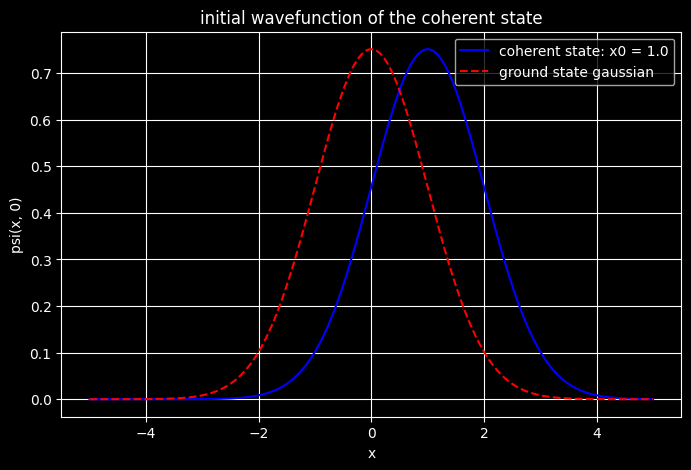

In [5]:
#part a.1
m, omega, hbar = 1,1,1
#for part a: x0 = sqrt(hbar * m * omega)
x_0 = np.sqrt(hbar * m * omega)
# create x values
x = np.linspace(-5, 5, 500)
# compute coherent state wavefunction
psi = initial_wavefunction(x, x_0, m, omega, hbar)
plot_wavefunction(x, psi, x_0, m, omega, hbar, save_as_png=True, file_name=r'part_a_x0.png')

### part b: asked to calculate overlap integral

we know that any state can be expressed as a sum over the energy eigenstates c_n. in this case for QHO the intial state (gaussian) can be expanded as:

  psi(x, 0) = sum (n = 0 to infinity) [ c_n * psi_n(x) ]

and we know psi_n(x) are eigenfunction and we can find c_n given by:

  c_n = ∫ [ psi_n*(x) * psi(x, 0) ] dx ... (1) mcyintyre ch 9

#### for its eigenstates

we know eigen states:

  psi_n(x) = (1/sqrt(2^n * n!)) * (m*omega/(pi*hbar))^(1/4) * H_n(xi) * exp( -xi²/2 )

where xi = sqrt(m*omega/hbar) * x and H_n(xi)

#### for a given coherent state we can say:

  c_n = exp( -alpha² / 2 ) * (alpha^n / sqrt(n!) )

again, alpha is:

  alpha = x_0 * sqrt( m * omega / (2 * hbar) )

and this is a poisson distro and thus we can say:
- at small alpha most weight is in ground state
- larger alpha, higher energy levels contribute more

#### from this we take:

- any quantum state can be expressed as a linear combo of complete sets of eigenstates. here psi(x,0) is written in basis of QHO.

- a given coherent state is just a displaced version (by x_0) of ground state that is the 'maximially uncertainity' (hbar/2 square box in phase space as shown in class)
   - its expansion coefficients follow poisson distro
  
- I believe the alpha param shows the displacement in phase space.
   -average number of quanta present in the state and thus will influence our distribtion via expansion coefficients
  
- For solving this problem:
  -I'll calculate overlap integrals numerically and compare them to analytical result.
  -I'll also check the norm of the sum of C_n **2 which should give us a hint if the first 10 are enough.

n	numerical	analytic
0	0.77880		0.77880
1	0.55070		0.55070
2	0.27535		0.27535
3	0.11241		0.11241
4	0.03974		0.03974
5	0.01257		0.01257
6	0.00363		0.00363
7	0.00097		0.00097
8	0.00024		0.00024
9	0.00006		0.00006

numerical normalization sum: 1.00000
analytic normalization sum: 1.00000


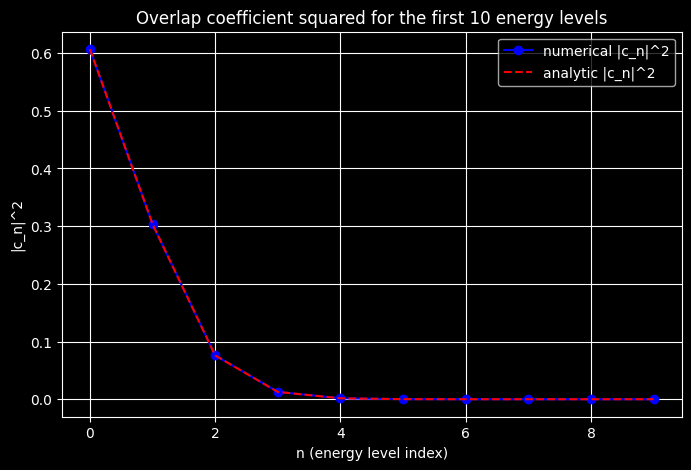

plot saved as part_a_x0.png


<Figure size 640x480 with 0 Axes>

In [6]:
#part b
x_0 = np.sqrt(hbar * m * omega)  #b.1 (first x_0)
n_max = 10
compute_overlap(x_0, n_max, m, omega, hbar, save_as_png=True, file_name='part_a_x0.png')


### for part c we want the expectation energy value for a coherent state of QHO
- Hamiltonian is H = p**2 / 2m +1/2mw**2 xhat**2
- Eigen Energystates |n> of the QHO are solutions to the time-indepdendent schrodinger (and related to hermite polys)
    - E_n = (n+1/2)hbar*w
-<E> = sum (n=0 -> inf)[|c_n|**2]E_n
    - here c_n = <n|psi(0)>

In [7]:
#part c
#re calc with function analytic coefficient
c_n_analytic = analytic_coefficients(n_max, x_0, m, omega, hbar)

#show output
expectation_energy = expectation_value_energy(c_n_analytic, omega, hbar)
print(f"Expectation value of energy: {expectation_energy:.5f}")

Expectation value of energy: 1.00000


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved as time_evolved_part_a.gif


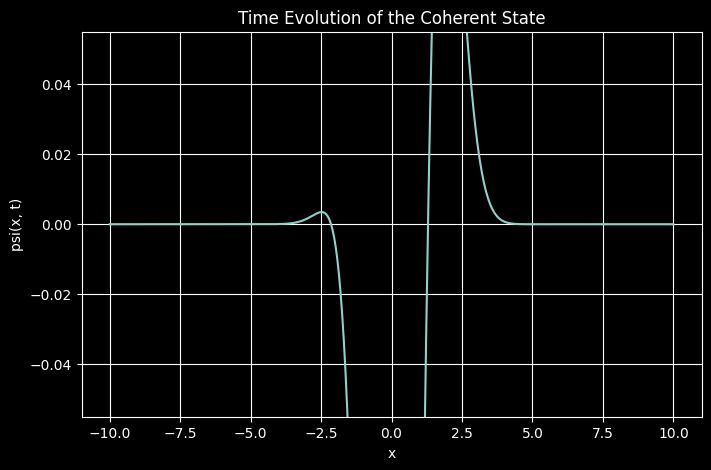

In [8]:
#part d params
x = np.linspace(-10, 10, 1000)  #position range
x_0 = np.sqrt(hbar * m * omega)  #same displacement, haven't moved to e yet
n_max = 10  #num of terms
time_steps = np.linspace(0, 20, 500) #time steps

#again compute analytic coefficients
c_n_analytic = analytic_coefficients(n_max, x_0, m, omega, hbar)

#call ani.
animate_wavefunction(x, time_steps, c_n_analytic, omega, hbar, save_as_gif=True, file_name='time_evolved_part_a.gif')


plot saved as part_e_x0.png
n	numerical	analytic
0	0.01832		0.01832
1	0.05180		0.05180
2	0.10361		0.10361
3	0.16919		0.16919
4	0.23927		0.23927
5	0.30266		0.30266
6	0.34948		0.34948
7	0.37361		0.37361
8	0.37361		0.37361
9	0.35225		0.35225
10	0.31506		0.31506
11	0.26868		0.26868
12	0.21938		0.21938
13	0.17209		0.17209
14	0.13009		0.13009
15	0.09501		0.09501
16	0.06718		0.06718
17	0.04608		0.04608
18	0.03072		0.03072
19	0.01994		0.01994

numerical normalization sum: 0.99975
analytic normalization sum: 0.99975


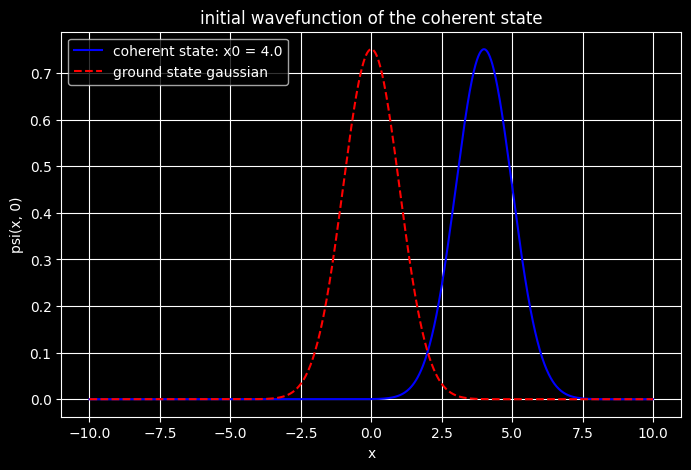

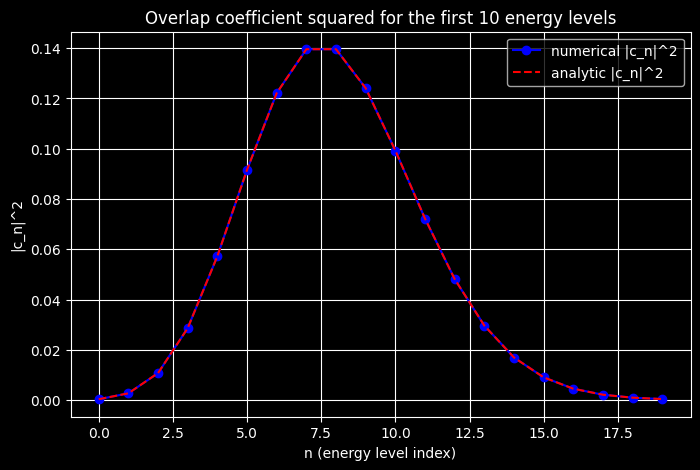

MovieWriter ffmpeg unavailable; using Pillow instead.


plot saved as part_e_x0_check.png
Expectation value of energy (new x_0): 8.49467
Animation saved as time_evolved_part_e.gif


<Figure size 640x480 with 0 Axes>

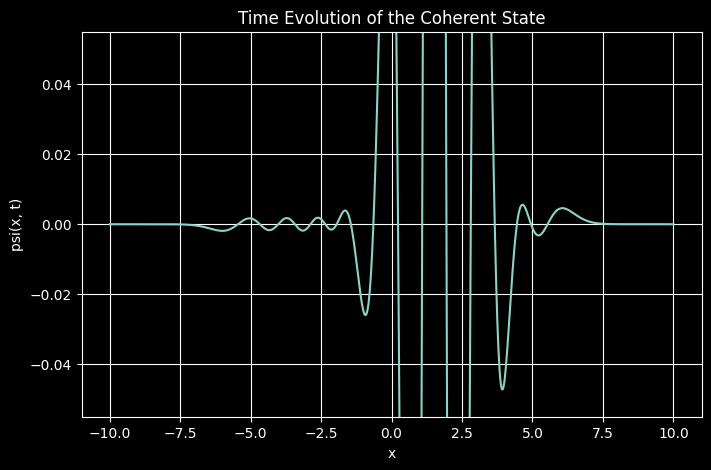

In [9]:
#part e redo on all with new displacement
x_0_new = 4 * np.sqrt(hbar * m * omega) #updated displacement
n_max_new = 20  #increase num of terms

#recompute
x = np.linspace(-10, 10, 1000)
psi_new = initial_wavefunction(x, x_0_new, m, omega, hbar)
plot_wavefunction(x, psi_new, x_0_new, m, omega, hbar, save_as_png=True, file_name='part_e_x0.png')

#compute overlap and save
compute_overlap(x_0_new, n_max_new, m, omega, hbar, save_as_png=True, file_name='part_e_x0_check.png')

#new expectation value of energy
c_n_new = analytic_coefficients(n_max_new, x_0_new, m, omega, hbar)
expectation_energy_new = expectation_value_energy(c_n_new, omega, hbar)
print(f"Expectation value of energy (new x_0): {expectation_energy_new:.5f}")

#animate and save
time_steps = np.linspace(0, 20, 500)
animate_wavefunction(x, time_steps, c_n_new, omega, hbar, save_as_gif=True, file_name='time_evolved_part_e.gif')


In [10]:
#housekeeping for plts  
move_plots()

Moved part_e_x0_check.png to graphs
Moved part_e_x0.png to graphs
Moved part_a_x0.png to graphs
Moved part_b_x0.png to graphs
Moved time_evolved_part_e.gif to graphs
Moved time_evolved_part_a.gif to graphs
